In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### (1) The probabilistic reversal learning task

During the fMRI scanning session participants carried out the PRL task in two conditions: (1) reward-seeking and (2) punishment-avoiding. Participants were instructed to repeatedly choose between yellow and blue boxes in order to collect as many points as possible in the reward-seeking condition or loose as little points as possible in the punishment-avoiding condition (**Fig. 1**). One of the boxes had the probability to be correct (rewarding or non-punishing depending on the condition) p = 0.8 and the other one p = 0.2. This reward contingency changed four times throughout each task condition. Reward probabilities were unknown to the subjects and had to be learned from experience. Each box had also associated reward magnitude, randomly selected at the beginning of each trial. These reward magnitudes represented as numbers within the box indicated possible gain in the reward-seeking condition or possible loss in the punishment-avoiding condition. To be successful in this task decision maker had to correctly estimate reward probabilities from experience and take into account reward magnitudes to choose an option with higher expected value. 
    
Each task condition was associated with the separate fMRI run and consisted of N=110 trials. Each trial began with the decision phase indicated by the question mark appearing within the fixation circle. During decision phase subject had 2 s to choose one of the boxes by pressing button on the response grip with either left or right thumb. Decision phase was followed by a variable inter-stimulus-interval (ISI; 3-7 s, jittered), after which an outcome was presented for 2 s. During the outcome phase fixation circle was colored accordingly to rewarded or punished box and the number within the circle represented number of gained or lost points (see **Fig. 1**). Outcome phase was followed by a variable inter-trial-interval (ITI; 3-7 s, jittered). 
    
    
The number of points which subject gathered in the reward-seeking condition or the remaining number of points in the punishment-avoiding conditions was represented by the gray account bar on the bottom of the screen. Subjects were informed that if they manage to fill half of the bar or the entire bar in the reward-seeking condition they will receive 10 PLN or 20 PLN respectively. In the punishment-avoiding condition subjects were informed that they will receive 20 PLN if they are left with more than half of the bar, 10 PLN if they are left with less than half of the bar or that do not receive any money if they lose all of their points. To maintain constant level of motivation throughout the task, incentives thresholds were set such that all participants acquired 10 PLN from either task.


PsychoPy software (v. 1.90.1, www.psychopy.org (Peirce, 2007)) was used for task presentation on the MRI compatible NNL goggles (NordicNeuroLab, Bergen, Norway). Behavioral responses were collected using MRI compatible NNL response grips (NordicNeuroLab, Bergen, Norway), which were hold in both hands.  Each condition lasted approximately 24 min. The order of task conditions as well as the colors for left and right box (yellow and blue) were counterbalanced across subjects. Before the MRI scan, subjects practiced both task conditions on the lab computer. 
Heterogeneity in the prior expectations regarding the task structure may lead to heterogeneity in behavior even in simple tasks leading to inaccurate behavioral modelling (Shteingart and Loewenstein, 2014). To tackle this challenge, we explicitly instructed participants that one of the boxes will be more frequently rewarded in the reward-seeking condition or punished in the punishment-avoiding condition and that this contingency may reverse several times during the task. In order to further ensure that participants grasp correct model of the task environment, they were provided with the feedback indicating which box is more frequently correct during the first phase of the training. 

![Figure 1](image/fig_1.png)


### (2) Processing of log dataframe

Each row of a dataframe represents *single trial*.
Description of useful dataframe columns:

Task characteristics:
- `block`: indicates which box is currently more likely to be rewarded / punished
- `rwd`: indicates which box is rewarded / punished on a given trial
- `magn_left` and `magn_right`: visible reward magnitudes

Subject responses:
- `response`: subject response
- `rt`: reaction time (max. 1.5 seconds)
- `won_bool`: indicates if subject won / not loose points
- `won_magn`: indicates number of points won / lost
- `acc_after_trial`: subject total points after given trial

Function `process_log_df()` cleans behavioral response dataframe changing data types, inverting interpretation of certain variables depending on task condition and drops irrelevant columns.

In [2]:
def process_log_df(df):
    '''Cleaning and pre-processing of log dataframe.
    
    Args:
        df (pd.Dataframe): raw log dataframe
        
    Returns:
        info (dictionary): contains task metadata
        df_clean (pd.Dataframe): pre-processed log dataframe
    '''
    df_clean = df.copy(deep=True)
    
    # Convert subject responses to integers
    df_clean.loc[df['response'] == 'a', 'response'] = -1
    df_clean.loc[df['response'] == 'd', 'response'] = 1
    try:
        df_clean.loc[df_clean['response'] == 'None', 'response'] = 0
    except TypeError:
        print('No missing responses.')

    # Convert reaction time to float
    df_clean['rt'] = pd.to_numeric(df_clean['rt'], errors='coerce')

    # Grab additional info                                                   
    info = {}
    info['n_trials'] = df_clean.shape[0]
    info['n_blocks'] = 5                                                     #TODO grab from data
    info['condition'] = df_clean['condition'][0]
    info['subject'] = df_clean['subject_id'][0]
    info['group'] = df_clean['group'][0]

    # Reverse the punishing interpretation of columns in punishment condition 
    # NOTE! 'block' and 'rwd' still have BEING CHOSEN interpretation
    if info['condition'] == 'pun':
        df_clean['won_magn'] *= (-1)  
        df_clean['won_bool'] = ~ df_clean['won_bool'] 
        df_clean['magn_left'] *= (-1)
        df_clean['magn_right'] *= (-1)

    # Drop unnecessary columns
    df_clean = df_clean[['block', 'rwd', 'magn_left', 'magn_right',
                         'response', 'rt',
                         'won_bool', 'won_magn', 'acc_after_trial']]

    return info, df_clean

In [151]:
# Load behavioral responses for signle subject
path_rew = "logs/sub-m05/m05_prl_DecideNet_rew.csv"
path_pun = "logs/sub-m05/m05_prl_DecideNet_pun.csv"

df_rew = pd.read_csv(path_rew)
df_pun = pd.read_csv(path_pun)

# Clean behavioral responses
info_rew, df_rew = process_log_df(df_rew)
info_pun, df_pun = process_log_df(df_pun)

df_rew.head()

,block,rwd,magn_left,magn_right,response,rt,won_bool,won_magn,acc_after_trial
0,-1,-1,32,18,-1,0.555709,True,32,32
1,-1,-1,11,39,-1,0.354307,True,11,43
2,-1,-1,45,5,-1,0.522175,True,45,88
3,-1,-1,43,7,-1,0.595589,True,43,131
4,-1,-1,10,40,-1,0.403662,True,10,141


### (3) Visualisation of subject responses

In [153]:
def plot_response(df, info):
    '''Visualising useful aspects of subjects response'''
    
    col_blu = "#56B4E9" # left
    col_yel = "#F0E442" # right
    col_blu_d = "#0B3A54"

    # Determine begin and end of the blocks and rewarded side
    N_blocks = info['n_blocks']
    N_trials = info['n_trials']
    condition = info['condition']

    blocks = np.zeros((2, N_blocks+1), dtype='int')
    blocks[0, 0:N_blocks] = np.nonzero(df['block'].diff() != 0)[0] + 1
    blocks[0, N_blocks] = N_trials
    blocks[1, 0:N_blocks] = df.loc[blocks[0], 'block'][:-1]

    if condition == 'pun':
        blocks[1, :] *= (-1) 

    rt = pd.to_numeric(df['rt'], errors='coerce')

    x_trials = np.arange(1, N_trials+1)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(20, 10), facecolor='w')

    ### Subplot 1 ###############################################################
    # True reward contingencies (more profitable side)
    for i in range(N_blocks):

        if blocks[1, i] == -1:  col = col_blu
        else:                   col = col_yel

        ax1.fill_between(
            x=[blocks[0, i], blocks[0, i+1]], 
            y1=-1, y2=1, 
            color=col, alpha=.5)

    # Rewarded / punished side
    ax1.scatter(x_trials, df.rwd*.9, c=df.rwd, cmap='cividis', vmin=-1.5, vmax=1.5)
    ax1.set_ylim(-1, 1)
    ax1.set_yticklabels([])

    # Magnitude for left box
    ax1b = ax1.twinx()
    ax1b.plot(x_trials, df['magn_left'], color=col_blu_d)
    ax1b.set_ylabel('$x(t)$ for left box', color=col_blu_d)
    ax1b.set_xlim(1, N_trials)
    if condition == 'pun': 
        ax1b.set_ylim(-50, 0)
    else:               
        ax1b.set_ylim(0, 50)

    ### Subplot 2 ###############################################################
    # Misses
    for miss in np.argwhere(np.isnan(rt)):

        ax2.fill_between(
            x=[miss[0]+.5, miss[0]+1.5],
            y1=0, y2=1.5,
            color='r', alpha=.5)
    ax1b.set_xlim(1, N_trials+1)

    # Reaction times
    ax2.plot(x_trials, pd.to_numeric(df['rt'], errors='coerce'), 'r')
    ax2.set_ylabel('reaction time $[s]$', color='r')
    ax2.set_xticks(blocks[0, 1:-1])
    ax2.set_ylim(0, 1.5)
    ax2.grid(axis='x')

    # Account
    ax2b = ax2.twinx()
    ax2b.plot(x_trials, df.acc_after_trial, 'k--')
    ax2b.set_ylabel('account balance')

    ### Subplot 3 ###############################################################
    ax3.scatter(x_trials, df.response*.75, c=df['won_bool'], 
                cmap='RdYlGn', vmin=-.2, vmax=1.2)
    ax3.set_ylim(-1, 1)
    ax3.set_yticks([-0.75, 0, .75])
    ax3.set_yticklabels(['left', 'miss', 'right'])
    ax3.grid(axis='both')

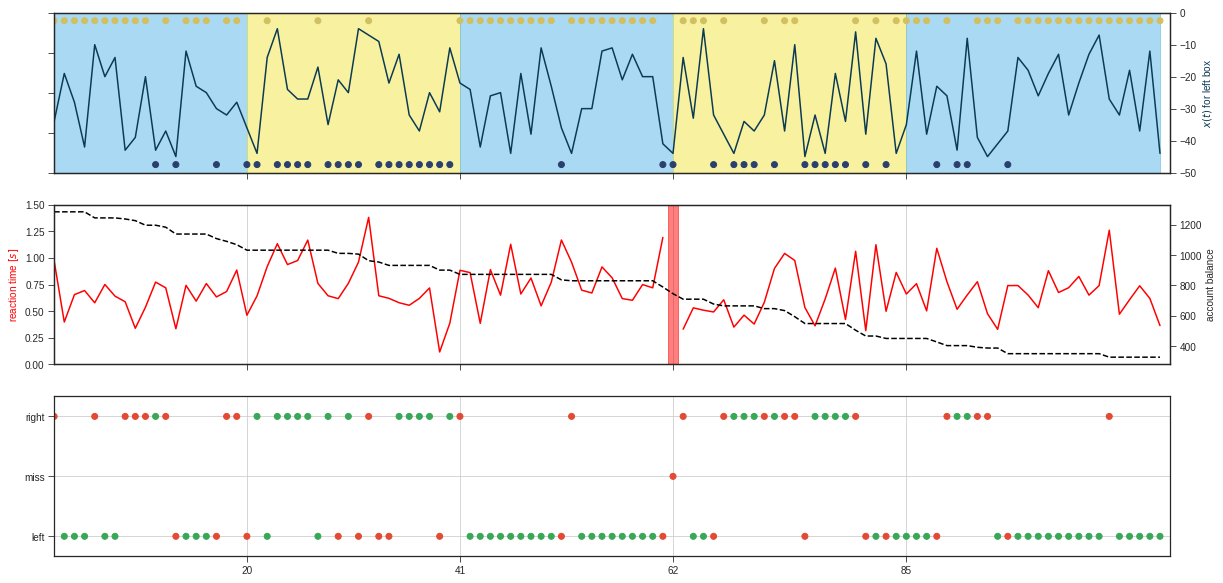

In [155]:
plot_response(df_pun, info_pun)

### Behavioral modelling

#### Assumptions:

- experienced utility is proportional to displayed reward magnitude: 
$$u(x) = x$$
- values (reflecting beliefs about probability) are learned with simple delta learning rule (TD model):
$$V(a_t)=V(a_{t-1})+ \alpha [R-V(a_{t-i})]$$
- choice probabilites are computed with degenerate softmax with infinitely high inverse temperature (parsimoneous approach introduced by *Summerfield et al. 2011*):
$$p(a)=\frac{V(a)}{V(a)+V(b)}$$

Free parameters:

- $\alpha \in [0, 0.5]$: learning rate (modelling learning rate above half would result in model selecting previously rewarded / not punished option which is not realistic 

Questions:

- simultaneous update of both values?


In [141]:
def estimate_values(df, info, alpha):
    '''Implements TD learning model on experienced probabilistic outcomes.
    
    Args:
        df (pd.Dataframe): clean behavioral responses
        alpha (float): learning rate 
        
    Returns:
        val (np.array): reflects algorithm trialwise beliefs about 
            probabilities that box will be rewarded / punished
    '''
    
    val = np.zeros((info['n_trials'], 2))
    val[0] = [.5, .5] # Initial beliefs (agnostic)

    for trial, rwd in df['rwd'][:-1].iteritems():
        val[trial+1, 1] = val[trial, 1] + alpha * ((rwd + 1)/2 - val[trial, 1])
        val[trial+1, 0] = val[trial, 0] + alpha * ((-rwd + 1)/2 - val[trial, 0])    

    return val

def estimate_utilities(df, info, gamma=1, delta=1):                                               
    '''Implements function converting reward magnitude to experienced utility.
    
    Args:
        df (pd.Dataframe): clean behavioral responses
        gamma (float): loss aversion parameter
        delta: (float): risk aversion parameter
        
    Returns:
        util (np.array): reflects algorithm trialwise estimates of utility 
            for both left and right boxes
    
    '''
    
    util = np.zeros((info['n_trials'], 2))
    
    if info['condition'] == 'pun': 
        factor = (-1) * gamma
    else:
        factor = 1
        
    util[:, 0] = factor * np.power(np.abs(df['magn_left']), delta)
    util[:, 1] = factor * np.power(np.abs(df['magn_right']), delta)

    return util

def estimate_choice_probability(df, val, util, kind='simple', theta=None):
    '''Implements softmax decision rule reflecting choice probabilities'''

    # Calculate expected value for both options
    ev = np.multiply(util, val)
    
    if kind == 'simple':
        p = ev / np.sum(ev, axis=1)[:, np.newaxis]
        if np.sum(ev) < 0: 
            p = np.fliplr(p)
        
    elif kind == 'softmax':
        p = np.exp(theta * ev) / np.sum(np.exp(theta * ev), axis=1)[:, np.newaxis]

    return p

def g_square(df, p):
    '''Calculate badness-of-fit quality measure. G-square is inversely 
    related to log likelyhood.'''

    ll = 0 

    for i, resp in df['response'].iteritems():

        if resp == -1:
            ll += np.log(p[i, 0])
        elif resp == 1:
            ll += np.log(p[i, 1])

    return (-2) * ll

### Behavioral Models #######################################################
def model1(df, info, alpha):
    '''Simple one-parameter model with variable learning rate.'''
    
    val = estimate_values(df, info, alpha)
    util = estimate_utilities(df, info)
    p = estimate_choice_probability(df, val, util, kind='simple')
    
    return p
    
    
def model2(df, info, alpha, theta):
    '''Two-parameter model  with variable learning rate and inverse T.'''
    
    val = estimate_values(df, info, alpha)
    util = estimate_utilities(df, info)
    p = estimate_choice_probability(df, val, util, kind='softmax', theta=theta)
    
    return p

def model3(df, info, alpha, theta, gamma, delta):
    '''Four-parameter model.
    
    Params:
        df (pd.Dataframe): clean behavioral responses
        alpha (float): learning rate
        theta (float): inverse softmax temperature
        gamma (float): loss aversion
        delta (float): risk aversion 
    '''
    
    val = estimate_values(df, info, alpha)
    util = estimate_utilities(df, info, gamma, delta)
    p = estimate_choice_probability(df, val, util, kind='softmax', theta=theta)
    
    return p

### Show example model fit for models 1 and 2

In [142]:
N_grid = 100

alpha = np.linspace(0, 1, N_grid)
theta = np.linspace(0, .5, N_grid)

### Model 1 #################################################################
fit1 = np.zeros((2, N_grid))

for i, a in enumerate(alpha):
    fit1[0, i] = g_square(df_rew, model1(df_rew, info_rew, a))
    fit1[1, i] = g_square(df_pun, model1(df_pun, info_pun, a))
    
### Model 2 #################################################################
av, tv = np.meshgrid(alpha, theta)

fit2 = np.zeros((2, N_grid, N_grid))
for i, a in enumerate(alpha):
    for j, t in enumerate(theta):
        fit2[0, i, j] = g_square(df_rew, model2(df_rew, info_rew, a, t))
        fit2[1, i, j] = g_square(df_pun, model2(df_pun, info_pun, a, t))    

/home/kmb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log
/home/kmb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in log


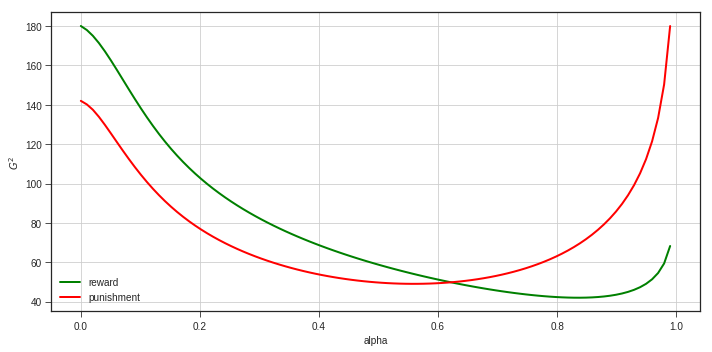

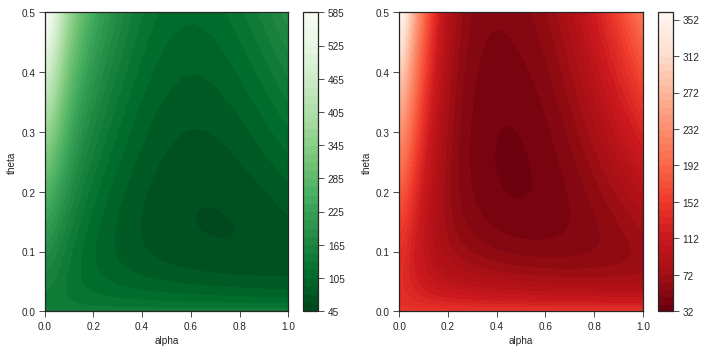

In [143]:
plt.style.use('seaborn-ticks')

# Figure 1
fig1, ax = plt.subplots(facecolor='w', figsize=(10, 5))
ax.plot(alpha, fit1[0,:], linewidth=2, color='g', label='reward')
ax.plot(alpha, fit1[1,:], linewidth=2, color='r', label='punishment')

ax.set_ylabel('$G^2$')
ax.set_xlabel('alpha')
ax.legend()
ax.grid()

plt.tight_layout()

# Figure 2
fig2, (ax2r, ax2p) = plt.subplots(nrows=1, ncols=2, facecolor='w', figsize=(10, 5))
im2r = ax2r.contourf(alpha, theta, fit2[0].T, levels=50, cmap='Greens_r')
im2p = ax2p.contourf(alpha, theta, fit2[1].T, levels=50, cmap='Reds_r')

ax2r.set_xlabel('alpha')
ax2r.set_ylabel('theta')
ax2p.set_xlabel('alpha')
ax2p.set_ylabel('theta')

fig2.colorbar(im2r, ax=ax2r)
fig2.colorbar(im2p, ax=ax2p)

plt.tight_layout()

### Model fitting for single subject responses

In [145]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

In [147]:
results = {}
results['model1'] = {'k': 1, 'g_square': None, 'x': None}
results['model2'] = {'k': 2, 'g_square': None, 'x': None}
results['model3'] = {'k': 4, 'g_square': None, 'x': None}

### Model 1 #################################################################
bounds1 = Bounds([0], [1])

def cost_model1(x):
    '''Optimization function for model 1.'''
    g_rew = g_square(df_rew, model1(df_rew, info_rew, x))
    g_pun = g_square(df_pun, model1(df_pun, info_pun, x))
    return g_rew  + g_pun

x0 = np.array([.5])

res1 = minimize(cost_model1, x0, method='SLSQP', bounds=bounds1)
results['model1']['g_square'] = res1['fun']
results['model1']['x'] = res1['x']

### Model 2 #################################################################
bounds2 = Bounds([0, 0], [1, np.inf])

def cost_model2(x):
    '''Optimization function for model 2.'''
    g_rew = g_square(df_rew, model2(df_rew, info_rew, x[0], x[1]))
    g_pun = g_square(df_pun, model2(df_pun, info_pun, x[0], x[1]))
    return g_rew + g_pun

x0 = np.array([.5, .5])

res2 = minimize(cost_model2, x0, method='SLSQP', bounds=bounds2)    
results['model2']['g_square'] = res2['fun']
results['model2']['x'] = res2['x']

### Model 3 #################################################################
bounds3 = Bounds([0, 0, 0, 0], [1, np.inf, np.inf, 1])

def cost_model3(x):
    '''Optimization function for model 2.'''
    g_rew = g_square(df_rew, model3(df_rew, info_rew, x[0], x[1], x[2], x[3]))
    g_pun = g_square(df_pun, model3(df_pun, info_pun, x[0], x[1], x[2], x[3]))
    return g_rew + g_pun

x0 = np.array([.5, .5, 1, 1])

res3 = minimize(cost_model3, x0, method='SLSQP', bounds=bounds3)    
results['model3']['g_square'] = res3['fun'] 
results['model3']['x'] = res3['x']

/home/kmb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log
/home/kmb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in log


### Model comparison for single subject

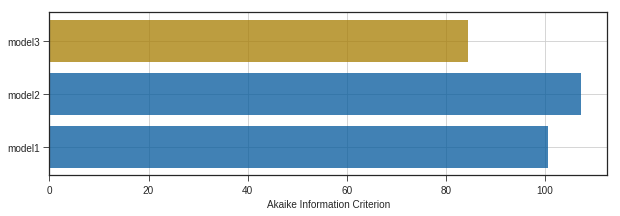

In [148]:
aic = np.zeros(3)

for i, model in enumerate(results):
    aic[i] = results[model]['g_square'] + 2*results[model]['k']

plt.style.use('seaborn-ticks')

fig, ax = plt.subplots(facecolor='w', figsize=(10, 3))

color = ['#01579B' for _ in range(3)]
color[np.argmin(aic)] = '#A67C00'
ax.barh(range(3), aic, color=color, alpha=.75)
ax.set_xlabel('Akaike Information Criterion')
ax.set_yticks(range(3))
ax.set_yticklabels(['model1', 'model2', 'model3'])
ax.grid()

### Distribution of model parameters across subjects